In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Data Import - Accepted Data

In [3]:
# load accepted data
accepted_data  = pd.read_csv("accepted_2007_to_2018q4.csv")

In [4]:
accepted_data.shape

(2260701, 151)

In [5]:
accepted_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


# Data Prep

## *Data Selection using Issue Date and Loan Status*

In [8]:
# find the right data to use, using the issue date and volume
# List of date columns
date_columns = [
    'issue_d',  # The month which the loan was funded
    'earliest_cr_line',  # The month the borrower's earliest reported credit line was opened
    # 'last_pymnt_d',  # Last month payment was received
    # 'last_credit_pull_d'  # The most recent month LC pulled credit for this loan
]

In [9]:
# check date datatype
accepted_data[date_columns].dtypes

issue_d             object
earliest_cr_line    object
dtype: object

In [10]:
# convert object to datetime
for col in date_columns:
    accepted_data[col] = pd.to_datetime(accepted_data[col])

In [11]:
# we do not really need day and month
# transform to year
for col in date_columns:
    accepted_data[col + '_yr'] = accepted_data[col].dt.year

# drop original date columns
accepted_data.drop(columns=date_columns, inplace=True)

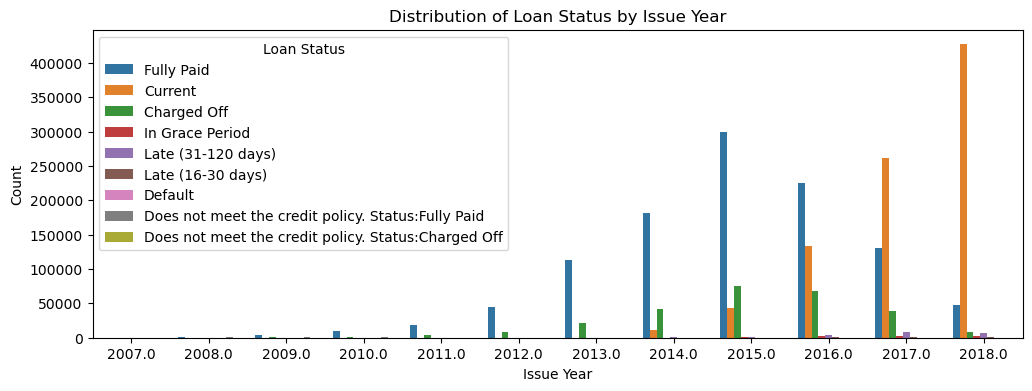

In [12]:
plt.figure(figsize=(12, 4))
sns.countplot(x='issue_d_yr', data=accepted_data,  hue='loan_status')
plt.title("Distribution of Loan Status by Issue Year")
plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

### *Dependent/Target Variable*

In [14]:
loan_status = accepted_data.groupby(['loan_status']).size()
loan_status = loan_status.reset_index(name='count')
loan_status

,loan_status,count
0,Charged Off,268559
1,Current,878317
2,Default,40
3,Does not meet the credit policy. Status:Charge...,761
4,Does not meet the credit policy. Status:Fully ...,1988
5,Fully Paid,1076751
6,In Grace Period,8436
7,Late (16-30 days),4349
8,Late (31-120 days),21467


In [15]:
# The Lending Club provides the description for each status:
# Current: The loan is up to date on all outstanding payments.
# In Grace Period: The loan is past due but within the 15-day grace period.
# Late (16–30): The loan has not been current for 16 to 30 days.
# Late (31–120): The loan has not been current for 31 to 120 days.
# Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
# Default: The loan has not been current for an extended period of time.
# Charged Off: Loan for which there is no longer a reasonable expectation of further payments.
# more here: https://www.lendingclub.com/help/investing-faq/what-do-the-different-note-statuses-mean

# choosing to base the analysis on confirmed good and bad
# exclude_data = ((accepted_data['loan_status'] == 'Current') | 
#                 (accepted_data['loan_status'] == 'In Grace Period') | 
#                 (accepted_data['loan_status'] == 'Late (16-30 days)') | 
#                 (accepted_data['loan_status'] == 'Late (31-120 days)')
#                )

include_data = ((accepted_data['loan_status'] == 'Fully Paid') | 
                (accepted_data['loan_status'] == 'Charged Off'))

accepted_data = accepted_data[include_data]

In [16]:
bad_loans = ['Charged Off']

In [17]:
# categorize loans as 0 for 'Good Loan' (low credit risk) or 1 for 'Bad Loan' (high credit risk) based on loan status (dependent variables)
accepted_data['target'] = np.where(accepted_data['loan_status'].isin(bad_loans), 1, 0)

In [18]:
target = accepted_data.groupby(['loan_status', 'target']).size()
target = target.reset_index(name='count')
target

,loan_status,target,count
0,Charged Off,1,268559
1,Fully Paid,0,1076751


### *Loan Status*

In [20]:
# to also understand the data better - i'd take a look at the loan_status as well    
# use a function to create a pivot table with issue_d and loan_status as index and column to understand both
def create_loan_status_pivot_table(data):
    pivot_table = data.pivot_table(index=data['issue_d_yr'], columns='loan_status', aggfunc='size', fill_value=0)
    pivot_table.loc['Grand Total'] = pivot_table.sum()
    pivot_table['Grand Total'] = pivot_table.sum(axis=1)
    
    return pivot_table

create_loan_status_pivot_table(accepted_data)

loan_status,Charged Off,Fully Paid,Grand Total
issue_d_yr,,,
2007.0,45,206,251
2008.0,247,1315,1562
2009.0,594,4122,4716
2010.0,1487,10049,11536
2011.0,3297,18424,21721
2012.0,8644,44723,53367
2013.0,21024,113780,134804
2014.0,41161,181941,223102
2015.0,75803,299742,375545


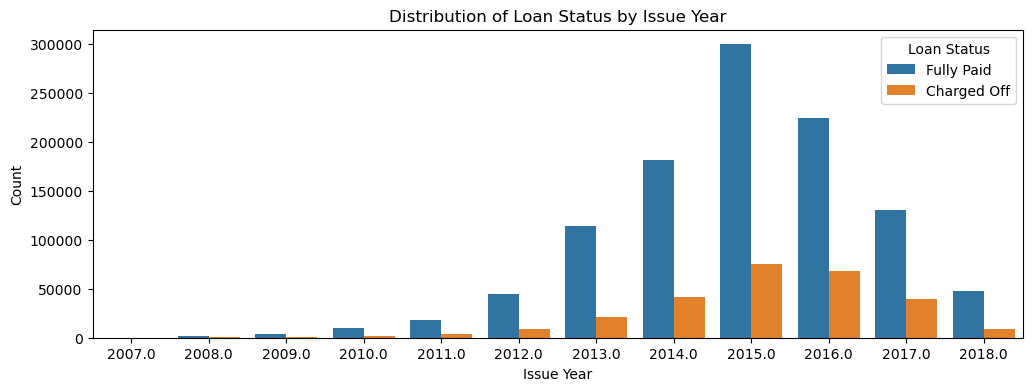

In [21]:
plt.figure(figsize=(12, 4))
sns.countplot(x='issue_d_yr', data=accepted_data,  hue='loan_status')
plt.title("Distribution of Loan Status by Issue Year")
plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

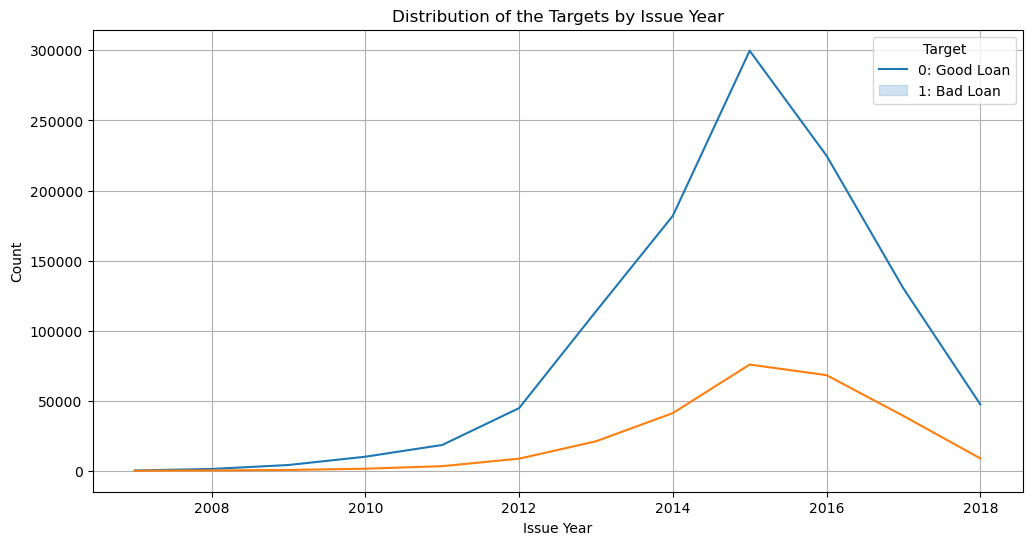

In [22]:
counts = accepted_data.groupby(['issue_d_yr', 'target']).size().reset_index(name='count')
plt.figure(figsize=(12, 6)) 
sns.lineplot(x='issue_d_yr', y='count', hue='target', data=counts)

plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Target', labels=['0: Good Loan', '1: Bad Loan'])
plt.title("Distribution of the Targets by Issue Year")

plt.grid(True) 
plt.show()

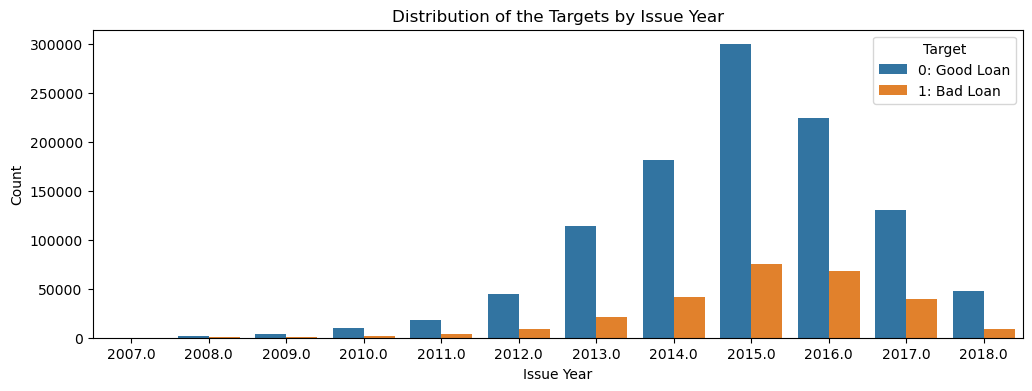

In [23]:
# accepted_data['target'] = accepted_data['target'].astype('category')
plt.figure(figsize=(12, 4))
sns.countplot(x='issue_d_yr', data=accepted_data, hue=accepted_data['target'].astype(str))

plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Target', labels=['0: Good Loan', '1: Bad Loan'])
plt.title("Distribution of the Targets by Issue Year")
plt.show()

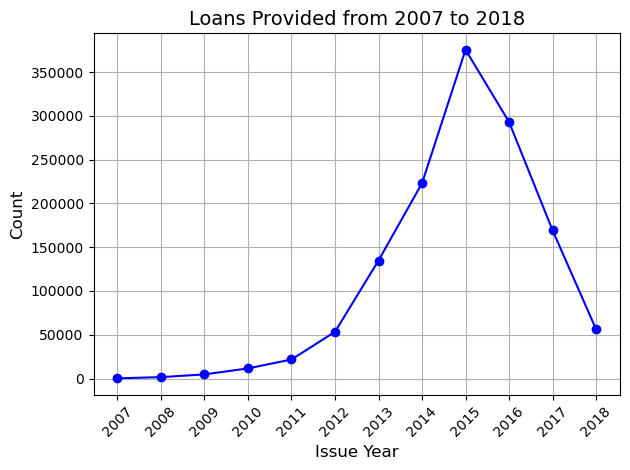

In [24]:
accepted_data.groupby('issue_d_yr')['loan_amnt'].size().plot(kind='line', linestyle='-', marker='o', color='b')

plt.xlabel('Issue Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Loans Provided from 2007 to 2018', fontsize=14)
plt.grid(True)
plt.xticks(ticks=range(2007, 2019), labels=range(2007, 2019), rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# using data with the highest volumes - 2015 to 2017 (also ensuring that the targets are unaffected)
# In-time Data (2015-2017):
# This data is used for training and building the models, and by using multiple years of data, I can increase the robustness of the models and account for any seasonality or trends that might exist over time
# Out-of-time Validation (2018):
# The data from 2018, which was not used during model training, is reserved for validation purposes. It serves as a test set to evaluate the performance of your models on unseen data.
# this helps assess their generalization ability and ensures that they can make accurate predictions on new, unseen data.
# If the models perform well on the out-of-time validation set, it provides confidence that they are capable of making accurate predictions in real-world scenarios.

# This approach mimics real-world scenarios where models need to generalise to new data.
    
# accepted_data = accepted_data[((accepted_data['issue_d_yr']) >= 2016) & ((accepted_data['issue_d_yr']) < 2018)]
# accepted_data = accepted_data[(accepted_data['issue_d_yr']) < 2018]
# accepted_data = accepted_data[(accepted_data['issue_d_yr']) == 2017]

In [26]:
create_loan_status_pivot_table(accepted_data)

loan_status,Charged Off,Fully Paid,Grand Total
issue_d_yr,,,
2007.0,45,206,251
2008.0,247,1315,1562
2009.0,594,4122,4716
2010.0,1487,10049,11536
2011.0,3297,18424,21721
2012.0,8644,44723,53367
2013.0,21024,113780,134804
2014.0,41161,181941,223102
2015.0,75803,299742,375545


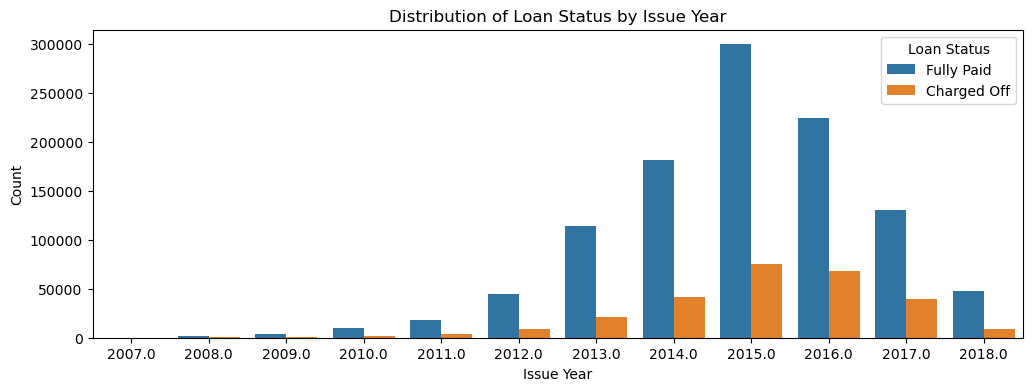

In [27]:
plt.figure(figsize=(12, 4))
sns.countplot(x='issue_d_yr', data=accepted_data,  hue='loan_status')
plt.title("Distribution of Loan Status by Issue Year")
plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

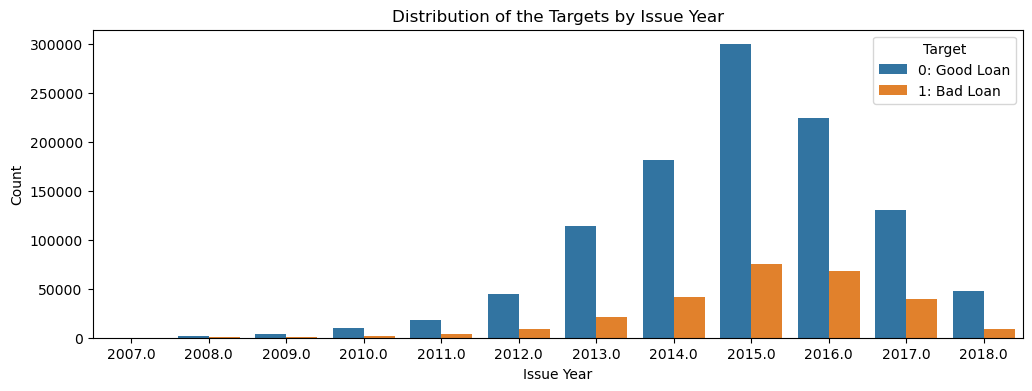

In [28]:
plt.figure(figsize=(12, 4))
sns.countplot(x='issue_d_yr', data=accepted_data, hue=accepted_data['target'].astype(str))

plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Target', labels=['0: Good Loan', '1: Bad Loan'])
plt.title("Distribution of the Targets by Issue Year")
plt.show()

                  

In [30]:
accepted_data.shape

(1345310, 152)

# Test Different Sampling Methods

In [32]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score)

In [33]:
non_null = accepted_data.dropna(axis=1)
# non_null

In [35]:
col_exclude = ['url', 'id', 'loan_status', 'recoveries', 'collection_recovery_fee', 'debt_settlement_flag',
               'hardship_flag', 'total_rec_late_fee', 'funded_amnt', 'funded_amnt_inv', 'total_rec_int',
               'policy_code', 'out_prncp_inv', 'out_prncp', 'last_fico_range_high', 'last_fico_range_low',
               'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt_inv', 'total_pymnt']

In [36]:
non_null = non_null.drop(columns=col_exclude)

In [37]:
# encode the categorical features
label_encoder = LabelEncoder()
for col in non_null.columns:
    if non_null[col].dtype == 'object':
        non_null[col] = label_encoder.fit_transform(non_null[col].astype(str)) 

In [38]:
imputer = SimpleImputer(strategy='mean')
non_null = pd.DataFrame(imputer.fit_transform(non_null), columns=non_null.columns)

### 10% Sample Size

In [40]:
sampled_data_10, _ = train_test_split(non_null, 
                                       test_size=1-0.10, 
                                       stratify=non_null['target'])

print(f'Total size: {len(sampled_data_10)}')

Total size: 134531


In [42]:
X_10 = sampled_data_10.drop(['target'], axis=1)  
y_10 = sampled_data_10['target']

In [44]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.20, random_state=42)

In [46]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_10, y_train_10)
xgb_y_pred_proba = xgb_model.predict_proba(X_test_10)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_10)

xgb_accuracy = accuracy_score(y_test_10, xgb_y_pred)
xgb_precision = precision_score(y_test_10, xgb_y_pred)
xgb_recall = recall_score(y_test_10, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test_10, xgb_y_pred_proba)

print("XGBoost Classifier (10%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (10%):
Accuracy: 0.8017
Precision: 0.4960
Recall: 0.1057
AUC-ROC: 0.7113


In [77]:
sampled_data_10, _ = train_test_split(accepted_data, 
                                       test_size=1-0.10, 
                                       stratify=accepted_data['loan_status'], 
                                       random_state=42)

sampled_data_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134531 entries, 927819 to 1815858
Columns: 152 entries, id to target
dtypes: float64(115), int64(1), object(36)
memory usage: 157.0+ MB


### 30% Sample Size

In [49]:
sampled_data_30, _ = train_test_split(non_null, 
                                       test_size=1-0.30, 
                                       stratify=non_null['target'])
print(f'Total size: {len(sampled_data_30)}')

Total size: 403593


In [51]:
X_30 = sampled_data_30.drop(['target'], axis=1)  
y_30 = sampled_data_30['target']

In [53]:
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, test_size=0.20, random_state=42)

In [55]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_30, y_train_30)
xgb_y_pred_proba = xgb_model.predict_proba(X_test_30)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_30)

xgb_accuracy = accuracy_score(y_test_30, xgb_y_pred)
xgb_precision = precision_score(y_test_30, xgb_y_pred)
xgb_recall = recall_score(y_test_30, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test_30, xgb_y_pred_proba)

print("XGBoost Classifier (30%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (30%):
Accuracy: 0.8059
Precision: 0.5451
Recall: 0.1076
AUC-ROC: 0.7194


In [75]:
sampled_data_30, _ = train_test_split(accepted_data, 
                                       test_size=1-0.30, 
                                       stratify=accepted_data['loan_status'], 
                                       random_state=42)

sampled_data_30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403593 entries, 1801169 to 1904688
Columns: 152 entries, id to target
dtypes: float64(115), int64(1), object(36)
memory usage: 471.1+ MB


### 50% Sample Size

In [58]:
sampled_data_50, _ = train_test_split(non_null, 
                                       test_size=1-0.50, 
                                       stratify=non_null['target'])

print(f'Total size: {len(sampled_data_50)}')

Total size: 672655


In [59]:
X_50 = sampled_data_50.drop(['target'], axis=1)  
y_50 = sampled_data_50['target']

In [62]:
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_50, y_50, test_size=0.20, random_state=42)

In [64]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_50, y_train_50)
xgb_y_pred_proba = xgb_model.predict_proba(X_test_50)[:, 1]
xgb_y_pred = xgb_model.predict(X_test_50)

xgb_accuracy = accuracy_score(y_test_50, xgb_y_pred)
xgb_precision = precision_score(y_test_50, xgb_y_pred)
xgb_recall = recall_score(y_test_50, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test_50, xgb_y_pred_proba)

print("XGBoost Classifier (50%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (50%):
Accuracy: 0.8044
Precision: 0.5530
Recall: 0.1027
AUC-ROC: 0.7225


In [81]:
sampled_data_50, _ = train_test_split(accepted_data, 
                                       test_size=1-0.50, 
                                       stratify=accepted_data['loan_status'], 
                                       random_state=42)

sampled_data_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672655 entries, 96523 to 180988
Columns: 152 entries, id to target
dtypes: float64(115), int64(1), object(36)
memory usage: 785.2+ MB


### 100% Sample Size

In [67]:
X = non_null.drop(['target'], axis=1)  
y = non_null['target']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [71]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_y_pred = xgb_model.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_auc_roc = roc_auc_score(y_test, xgb_y_pred_proba)

print("XGBoost Classifier (100%):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"AUC-ROC: {xgb_auc_roc:.4f}")

XGBoost Classifier (100%):
Accuracy: 0.8056
Precision: 0.5631
Recall: 0.0965
AUC-ROC: 0.7262


## Selected Data Size: Stratified Sampling

In [22]:
sample_size = 0.30

In [23]:
sampled_data, _ = train_test_split(accepted_data, 
                                       test_size=1-sample_size, 
                                       stratify=accepted_data['loan_status'], 
                                       random_state=42)

In [56]:
print(f"Sampling {sample_size * 100}% of the data:\nData: {len(accepted_data)} rows \nSample Size: {len(sampled_data)} rows")

Sampling 30.0% of the data:
Data: 1345310 rows 
Sample Size: 403593 rows


In [24]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403593 entries, 1801169 to 1904688
Columns: 152 entries, id to target
dtypes: float64(115), int32(1), object(36)
memory usage: 469.6+ MB


In [59]:
sampled_data.shape

(403593, 152)

In [61]:
create_loan_status_pivot_table(sampled_data)

loan_status,Charged Off,Fully Paid,Grand Total
issue_d_yr,,,
2007.0,13,60,73
2008.0,75,437,512
2009.0,153,1253,1406
2010.0,435,3030,3465
2011.0,1007,5531,6538
2012.0,2691,13445,16136
2013.0,6284,33877,40161
2014.0,12380,54756,67136
2015.0,22717,89726,112443


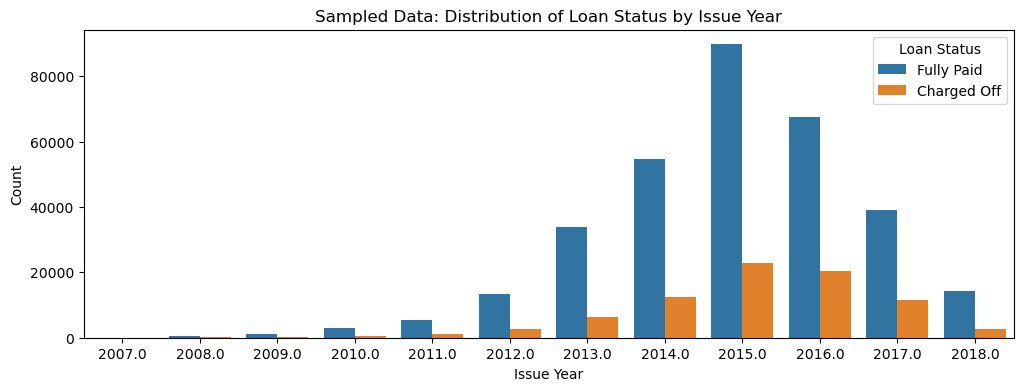

In [63]:
plt.figure(figsize=(12, 4))
sns.countplot(x='issue_d_yr', data=sampled_data,  hue='loan_status')
plt.title("Sampled Data: Distribution of Loan Status by Issue Year")
plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

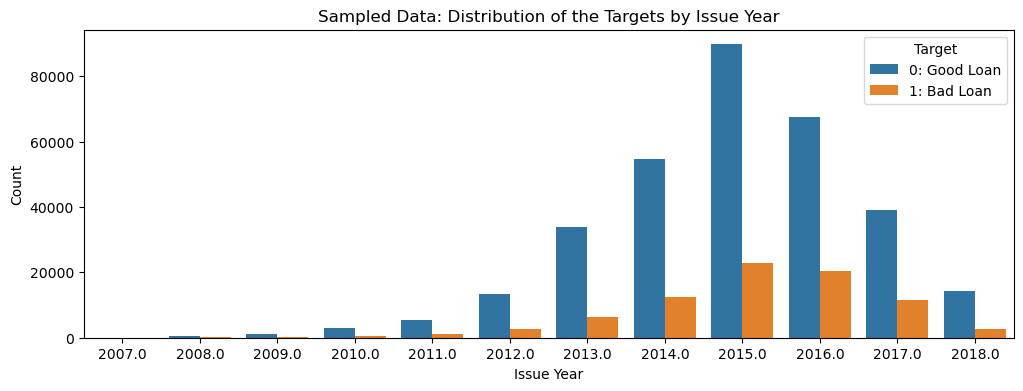

In [71]:
plt.figure(figsize=(12, 4))
sns.countplot(x='issue_d_yr', data=sampled_data, hue=sampled_data['target'].astype(str))

plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.legend(title='Target', labels=['0: Good Loan', '1: Bad Loan'])
plt.title("Sampled Data: Distribution of the Targets by Issue Year")
plt.show()

In [73]:
sampled_data.to_csv('sampled_data_30.csv', index = False)